<a href="https://colab.research.google.com/github/sbowma15/skin_detection_and_gamma_correction/blob/main/skin_detection_and_gamma_correction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

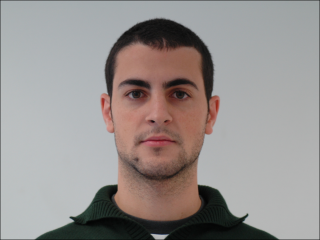

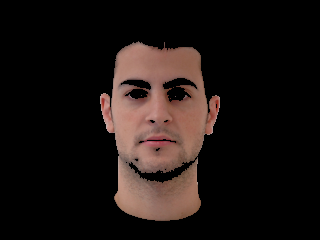

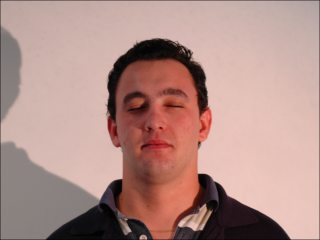

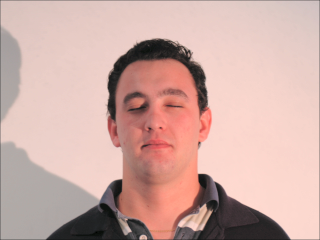

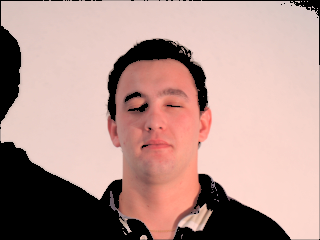

threshold 168


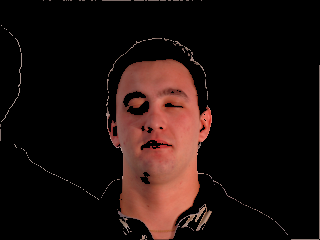

In [ ]:
################################################################################
# HW3, Shane Bowman, Computer Vision
################################################################################
import cv2 as cv
import numpy as np
from google.colab.patches import cv2_imshow


################################################################################

#Method to be used later with current gamma passed in. THe original image is
#converted to "LUV" and placed in "luv". The particular luminacne channel is now
#extracted and placed in "l". l contains values that need to be normalized so
#it can used in the power transmformation method with "gamma". Then
def luv_space_gamma( src, gamma) :

  luv = cv.cvtColor(src, cv.COLOR_BGR2LUV)

  #Extract Luminance channel
  l = luv[:,:,0]

  #normalize pixel values
  l = l / 225.0

  #apply power transform
  l = np.power(l, gamma)

  #scale back
  l = l * 225

  luv[:,:,0] = l.astype(np.uint8)

  rgb = cv.cvtColor(luv, cv.COLOR_LUV2BGR)

  return rgb

def skin_rgb_threshold( src ):
  #Extract color channels and save as SIGNED integers
  #Need the extra width for extraction
  #the numpy function, "np.int16" along with "astype()" converts the values into
  #a 16 point integer value
    b = src[:,:,0].astype(np.int16)
    g = src[:,:,1].astype(np.int16)
    r = src[:,:,2].astype(np.int16)

#This is the skin mask we went over in the video, The idea is to first find the
#areas of where red, green, and blue values are within the boundaries set
    skin_mask = ((r > 96) & (g> 40) & (b > 10)
#this will make sure that the difference between the maxes and minimums of the
#photo are not more than 15 unit values away from eachother.
              &((src.max()-src.min())>15)
#Now the absolute value is taken from the difference of the red and green values
#The absolute of the difference is compared to the maximum in differences which
#is 15 unit values, and where red is greater than green and blue pixel values
              &(np.abs(r-g)>15) & (r > g) & (r > b))

#This will return the src image with only the specified pixel values found to be
#overlapped with the original image pixel values
    return src * skin_mask.reshape(skin_mask.shape[0], skin_mask.shape[1],1)

#This method is used later when the methdod call's made and "hist", is passed in
#"hist" is the HISTOGRAM OF THE LUMINANCE OF THE PIXELS*** important note***
#Essentially the kernal below is used to deviate the luminance values of the
#histogram for further processing to automatically detect where largest areas of
#change between luminance is and then automatically turn the background pixels
#of the areas of largest luminance to a zero value, thus eliminating the photos
#background when overlapped with the original image again.
def find_local_min( hist ):

  kern = np.array(
          [2,0,0,0,
           2,0,0,0,
           2,0,0,0,
           1,0,0,0,
           1,0,0,0,
           1,0,0,0,
           1,0,0,0,
           -3,-3,-3,-3,
           -3,-3,-3,-3,
           0,0,0,1,
           0,0,0,1,
           0,0,0,1,
           0,0,0,1,
           0,0,0,2,
           0,0,0,2,
           0,0,0,2,
           0,0,0,2])

  #so many zeroes will throw off the convolution
  hist[0] = 0
  deriv = np.convolve(hist, kern, mode='same')
  threshold = deriv.argmax()
  return threshold, deriv

  #####################################################
  #start of main code
  #####################################################

#first read images in then do gamma correction

src1 = cv.imread('/content/sample_data/face_good.bmp')##########

cv2_imshow(src1)

#call to "skin_rgb_threshold" with the "face_good.bmp" image passed in as "src1"
#Return placed in "skin" and displayed below using "cv2_imshow"
skin = skin_rgb_threshold(src1)

cv2_imshow(skin)

########################################################
#start of solving face_dark.bmp
########################################################

###########################
#This portion doesnt solve the problem but changes the gamma###
src=cv.imread("/content/sample_data/face_dark.bmp")

cv2_imshow(src)

#gamma = luv_space_gamma(src, 0.6)
luv = cv.cvtColor(src, cv.COLOR_BGR2LUV)

#extract luminance channel, placed in "l"
l = luv[:,:,0]

#making it relative to pixel value scale
# normalize
l = l / 256.0

#apply power transform
l = l**0.6

##scale back
l = l * 256

luv[:,:,0] = l.astype(np.uint8)

gamma = cv.cvtColor(luv, cv.COLOR_LUV2BGR)

cv2_imshow(gamma)

#End gamma change block ##
################################

#converts pixel values back and uses the method "skin_rgb_threshold" with luv
#passed in and put into "rgb"
rgb = cv.cvtColor(luv, cv.COLOR_LUV2BGR)

#places the return into "skin", replacing previous skin value
skin = skin_rgb_threshold(rgb)

cv2_imshow(skin)

#####################################
#getting histogram of the luminance and search for local min
######################################

#converting values from BGR to LUV for luminance
luv = cv.cvtColor(src, cv.COLOR_BGR2LUV)

#splitting back into channels
l = luv[:,:,0]
u = luv[:,:,1]
v = luv[:,:,2]

#Returns a contigous flattened array which is then pasted in to numpy function,
#"np.histogram()". The return is put into "hist" as bins array
hist, bins = np.histogram(l.ravel(), 256, [0,256])

#"hist" passed into "find_local_min", return put into, "threshold" as ndarray,
#
threshold, deriv = find_local_min(hist)

#this is a good tool for viewing the threshold when changing around the kernal
#values.... Really lets you see what youre doing

#prints the threshold from the histograph with the label "threshold"
print('threshold', threshold)

#pretty self explanatory
#simple threshold operation sets all values below threshold to 0
l = (l<threshold) * l

#place the adjusted l channel back in to luv data matrix
luv[:,:,0] = l

#converts back to rgb and re-uses the skin detector, "skin_rgb_threshold()" with
#"rgb" passed in for final output
rgb = cv.cvtColor(luv, cv.COLOR_LUV2BGR)
skin = skin_rgb_threshold(rgb)
cv2_imshow(skin)









